# Building our decision tree

#### What we are actually doing
Learning a decision tree means learning a sequence of if/else questions that gets us to the true answer most quickly.
In the machine learning setting, these questions are called **tests** (not to be confused with the test set, which is the data we use to test to see how generalizable our model is).

We recursively split split the data based on these **tests**. This recursive process yields a binary tree of decisions, with each node containing a test.

Alternatively, you can think of each test as splitting the part of the data that is cur‐ rently considered along one axis. This yields a view of the algorithm as building a hierarchical partition. As each test concerns only a single feature, the regions in the resulting partition always have axis-parallel boundaries.

If we continue the recursive partitioning of the data until each region in the partition (each leaf in the decision tree) only contains a single target value (a single class or a single regression value), this will lead to **overfitting**.

**There are two common strategies to prevent overfitting**:
* **Pre-pruning**: stopping the creation of the tree early, or 
* **Post-pruning / a.k.a. Pruning**: building the tree but then removing or collaps‐ ing nodes that contain little information

(Possible criteria for pre-pruning include limiting the maximum depth of the tree, limiting the maximum number of leaves, or requiring a minimum number of points in a node to keep splitting it.)

A prediction on a new data point is made by checking which region of the partition of the feature space the point lies in, and then predicting the majority target (or the single target in the case of pure leaves) in that region. The region can be found by traversing the tree from the root and going left or right, depending on whether the test is fulfilled or not.

#### How to do it
Decision trees in scikit-learn are implemented in the `DecisionTreeRegressor` and `DecisionTreeClassifier` classes. Scikit-learn only implements pre-pruning, not post- pruning.

In [3]:
from preamble import *
from sklearn.datasets import load_breast_cancer
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

In [4]:
cancer = load_breast_cancer()

In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    cancer.data, cancer.target, stratify=cancer.target, random_state=42)

In [6]:
tree = DecisionTreeClassifier(random_state=0)

In [7]:
tree.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=0, splitter='best')

In [12]:
print("accuracy on training set: %f" % tree.score(X_train, y_train))
print("accuracy on test set: %f" % tree.score(X_test, y_test))

accuracy on training set: 1.000000
accuracy on test set: 0.937063


As expected, the accuracy on the training set is 100% as the leaves are pure. (Overfitting is happening!)

Now let’s apply pre-pruning to the tree, which will stop developing the tree before we perfectly fit to the training data.

In [13]:
tree_pre_pruned = DecisionTreeClassifier(max_depth=4, random_state=0)
tree_pre_pruned.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=0, splitter='best')

In [16]:
print("accuracy on training set: %f" % tree_pre_pruned.score(X_train, y_train))
print("accuracy on test set: %f" % tree_pre_pruned.score(X_test, y_test))

# Prepruning the tree leads to a lower accuracy on the training set, but an improvement on the test set.

accuracy on training set: 0.988263
accuracy on test set: 0.951049


### Analyzing Decision trees
We can visualize the tree using the export_graphviz function from the tree module. This writes a file in the dot file format, which is a text file format for storing graphs.

We set an option to color the nodes to reflect the majority class in each node and pass the class and features names so the tree can be properly labeled.

In [8]:
from sklearn.tree import export_graphviz

In [9]:
# Exporting the tree
export_graphviz(tree, out_file='my_tree.dot', class_names=["malignant", "benign"],
                    feature_names=cancer.feature_names, impurity=False, filled=True)

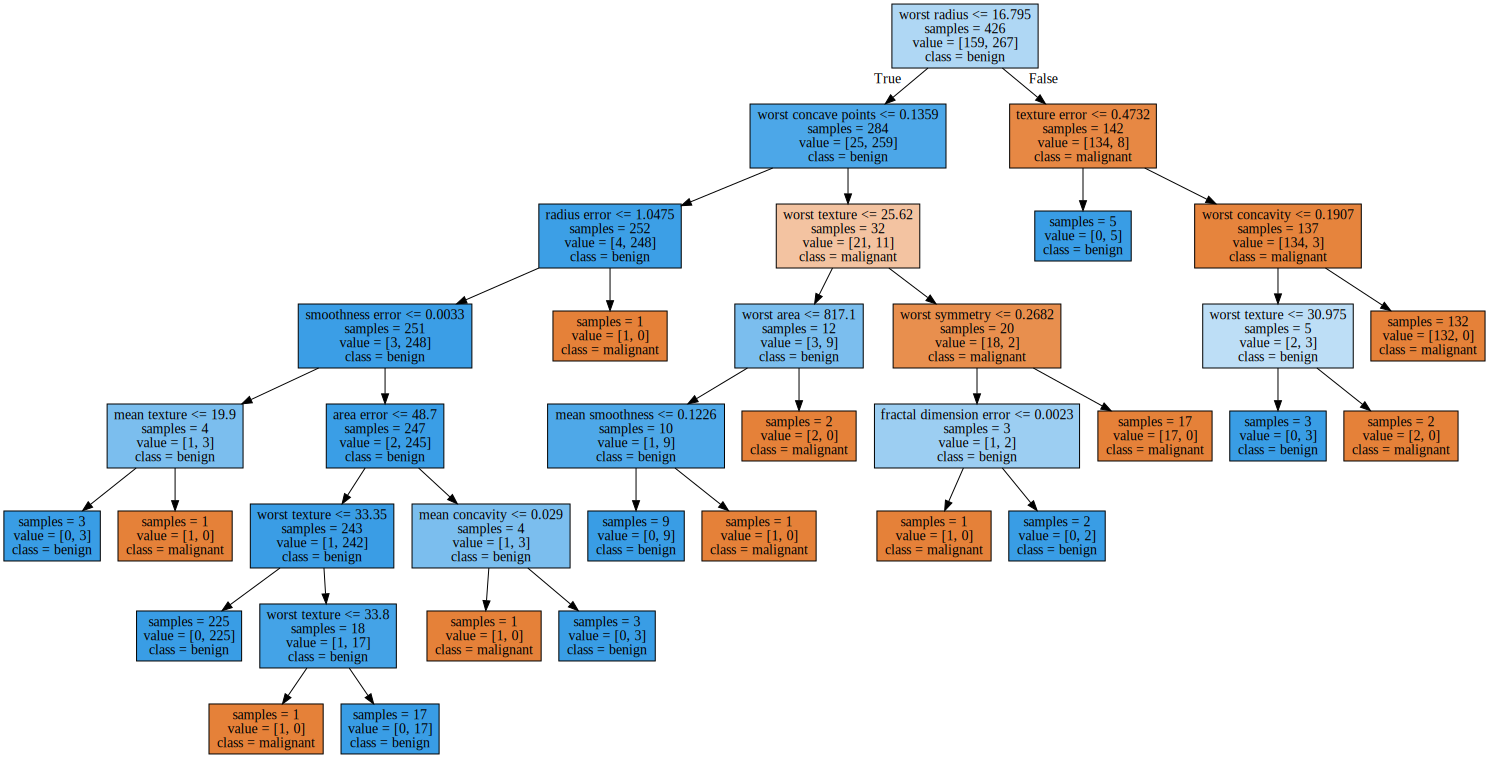

In [12]:
# Importing the tree
import graphviz

with open("my_tree.dot") as f:
    dot_graph = f.read()

graphviz.Source(dot_graph)

### How do we determine which feature is important in this model?

Scanning the tree graph above with our bare eyes can give a sense of which split contains the most data. However it's not the most scalable thing to do. Instead, sklearn gives us an attribute known as `.feature_importances_`

In [15]:
# Generating the feature importances of the tree (Note: they always sums to 1)

tree.feature_importances_

array([ 0.   ,  0.008,  0.   ,  0.   ,  0.009,  0.   ,  0.008,  0.   ,
        0.   ,  0.   ,  0.01 ,  0.046,  0.   ,  0.002,  0.002,  0.   ,
        0.   ,  0.   ,  0.   ,  0.007,  0.695,  0.054,  0.   ,  0.014,
        0.   ,  0.   ,  0.017,  0.117,  0.011,  0.   ])

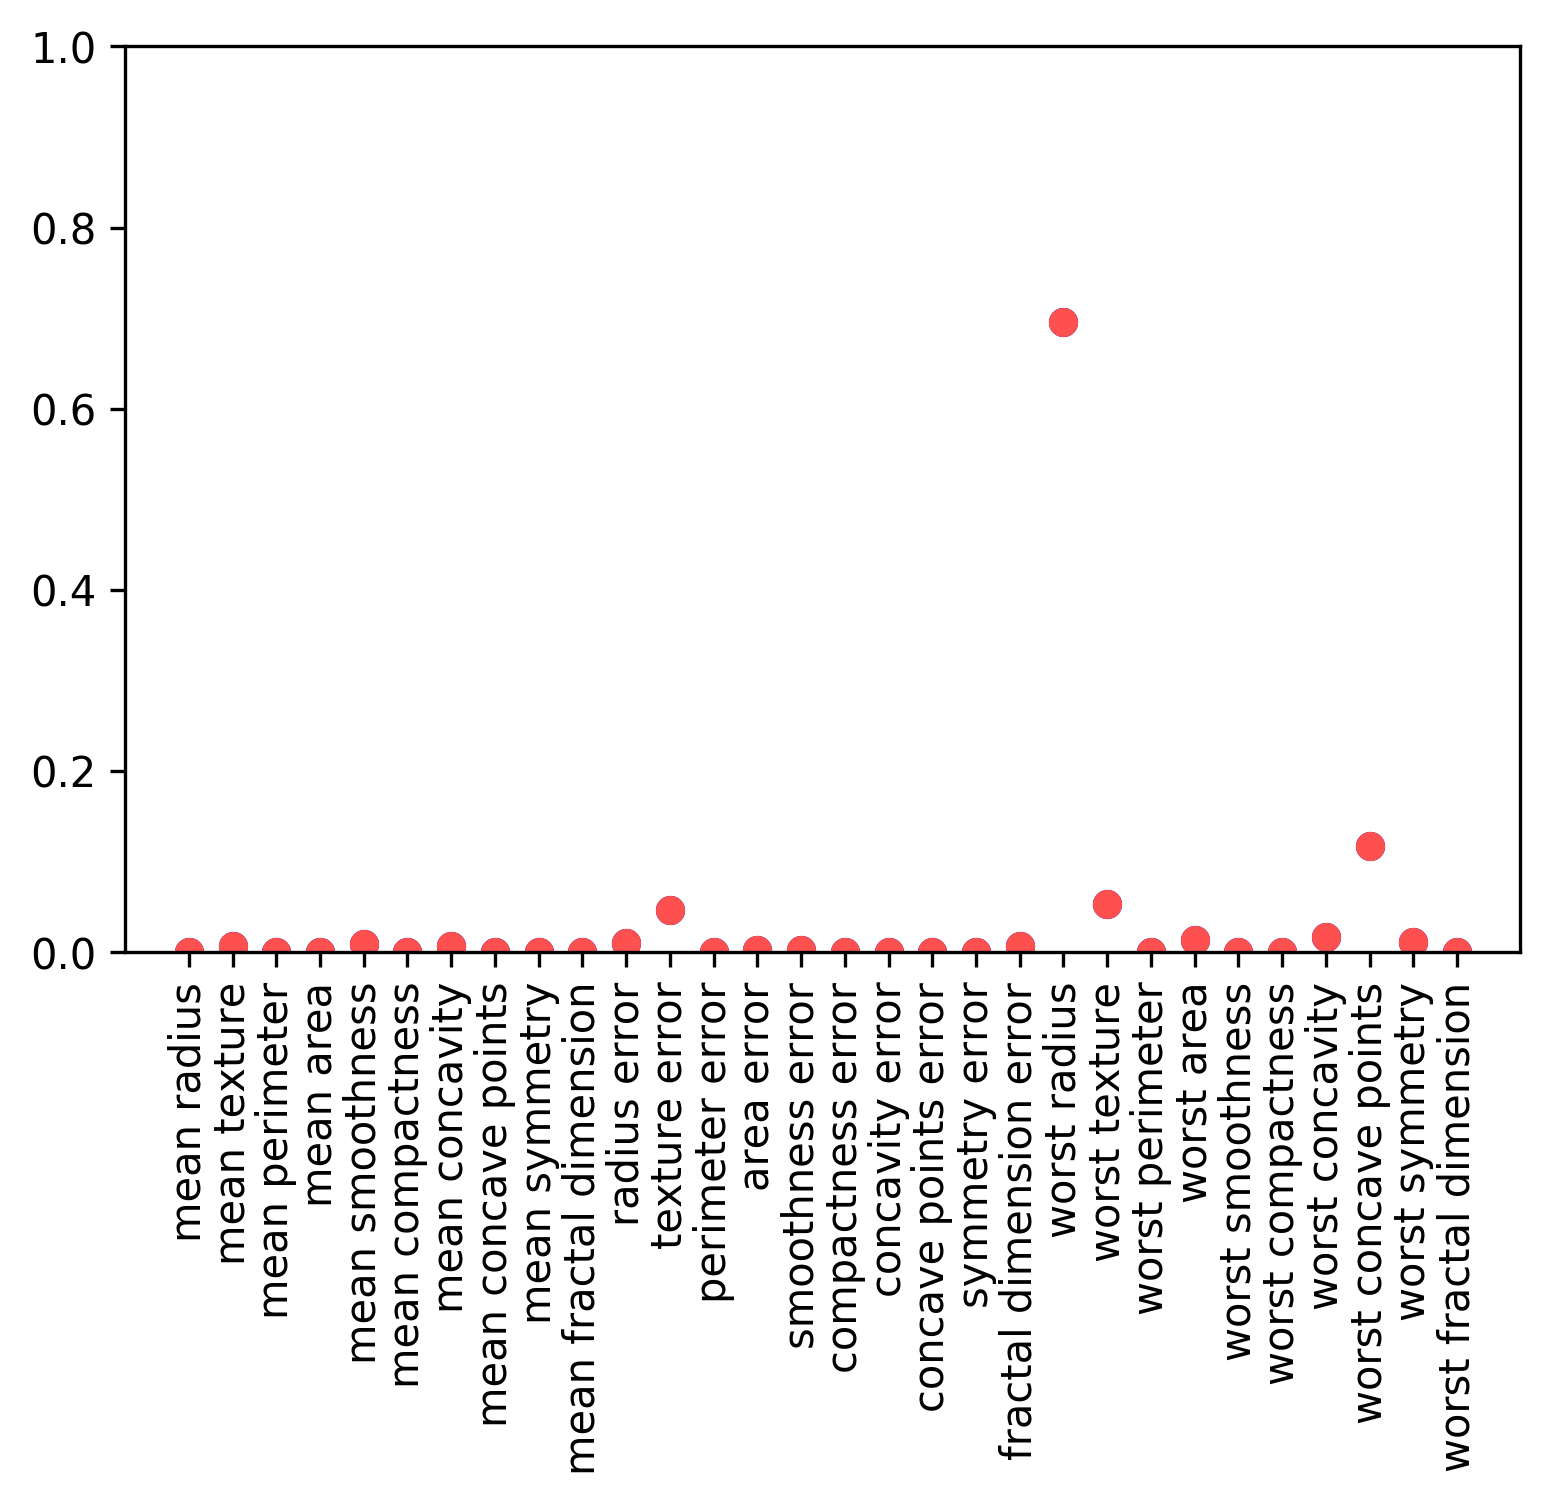

In [17]:
# Visualizing the feature importance
plt.plot(tree.feature_importances_, 'o')
plt.xticks(range(cancer.data.shape[1]), cancer.feature_names, rotation=90)

plt.ylim(0,1)
plt.show()

Here, we see that the feature used at the top split (“worst radius”) is by far the most important feature. 

However, if a feature has a low feature_importance, it doesn’t mean that this feature is uninformative. It only means that this feature was not picked by the tree, likely because another feature encodes the same information.